## Quadratic Assignment Problem (Symmetic)

## 1. Design and implement a greedy heuristic to create a solution to the QAP

In [3]:
import numpy as np
import random as rd

flow = np.array([
   [0, 9, 7, 1, 10],
   [9, 0, 10, 3, 7],
   [7, 10, 0, 4, 10],
   [1, 3, 4, 0, 4],
   [10, 7, 10, 4, 0]
])

dist = np.array([
   [0, 147, 511, 266, 405],
   [147, 0, 429, 285, 547],
   [511, 429, 0, 353, 772],
   [266, 285, 353, 0, 425],
   [405, 547, 772, 425, 0]
])

# cost function = flow*distance matrix 
#(sum only the upper triangle)
def cost(flow):
    global dist
    cost = flow*dist
    return np.sum(cost[np.triu_indices(5,1)])*2

# Random Approach: 
# Generate random solution with the random function 
def randHeu (mat):
    ndim = mat.shape[0]
    rand_sol = rd.sample(range(ndim), ndim)
    return mat[np.ix_(rand_sol,rand_sol)], rand_sol

rand = randHeu(flow)
print("Random Heuristic solution: " + str(rand[1]))
print("Random Heuristic solution's cost: " + str(cost(rand[0])))

Random Heuristic solution: [3, 4, 2, 1, 0]
Random Heuristic solution's cost: 56698


This random solution is generated with built-in function that generates random sequence 

## 2. Design and implement a random heuristic to create a solution to the QAP.

In [4]:
# Greedy Approach: 
# Find the respective largest range of the rows in the two matrix 
# match the smallest value with the largest value, second smallest to second largest
# and so on..
def idxMax(mat):
    maxrow = mat.max(axis=0) #find max value in each rows
    np.fill_diagonal(mat, 999)
    minrow = mat.min(axis=0) #find min value in each rows 
    np.fill_diagonal(mat, 0)
    max_range = maxrow - minrow # find the largest range 
    return np.where(max_range == np.amax(max_range))[0][0] #get index of the largest range
    
def idxSort(A, B):
    list_A = A[idxMax(A),0:] # get the row with largest range 
    list_B = B[idxMax(B),0:]
    
    zero_idx = np.where(list_A == 0)[0][0] #store index of zero in matrix A
    list_A = np.trim_zeros(list_A) #remove zeros 
    list_B = np.trim_zeros(list_B)
    list_B = np.sort(list_B)[::-1] #sort list B in desc order
    sorted_list = [list_B for _,list_B in sorted(zip(list_A,list_B))] #sort min in A match max in B
    sorted_list = np.insert(sorted_list, zero_idx, 0)

    res = []
    for i in sorted_list:
        b = B[idxMax(B),0:]
        res.append(np.where(b == i)[0][0]) # get the indices of sorted matrix 
    return res  

def greedHeu (matA, matB):
    global idx
    idx = idxSort(matA, matB)
    return matA[np.ix_(idx,idx)], idx

greedy = greedHeu(flow, dist)
print("Greddy Heuristic solution: " + str(greedy[1]))
print("Greedy Heuristic solution's cost: " + str(cost(greedy[0])))

Greddy Heuristic solution: [2, 1, 0, 4, 3]
Greedy Heuristic solution's cost: 45652


The greedy approach: select the respect row with largest range from the two matrix, match the position of the smallest value to the position of the largest value, second smallest to second largest and so on 

## 3. Implementing a simulated annealing algorithm to solve the QAP. Design a neighborhood to generate a solution s′ given a solution s.

In [5]:
sol_len = 5
N = 10 # size of neighboorhood matrix 
neighbors = np.zeros((N, sol_len +2), dtype=int)
# 2 Opt Neighborhood Approach: 
# swap the first two elements in the given solution, 
# move one spot to the right in the new solution list 
# and swap these two values in given solution to 
# form another new solution, make another one move to
# the right and perform same operation until the 
# end of the index in the solution list is reached 
# all of these new solutions (neighbors) form the 
# neighborhood matrix 
def swap_move(sol_n):
    global idx, neighbors
    #print idx
    for i in range (sol_len):
        j=i+1
        for j in range(sol_len):
            if  i<j:
                idx=idx+1 
                sol_n[j], sol_n[i] = sol_n[i], sol_n[j] #swap two elements 
                neighbors[idx, :-2] = sol_n
                neighbors[idx, -2:] = [sol_n[i], sol_n[j]]
                sol_n[i], sol_n[j] = sol_n[j], sol_n[i]

def return_neighbor(curnt_sol):
    global neighbors, idx
    idx = -1
    swap_move(curnt_sol)  # make a move to 2-opt neighboorhood 
    cost = np.zeros((len(neighbors)))  # holds the cost of the neighbors
    for index in range(len(neighbors)):
        cost[index] = solcost(neighbors[index, :-2])  # evaluate the cost of the candidate neighbors
    rank = np.argsort(cost)  # sorted index based on cost
    neighbors = neighbors[rank]
    k = []
    for n in range(N):
        k = rd.randint(0, N-1)
    return(neighbors[k,:-2]) # randomly select one of the neighbors

def solcost(sol):
    global flow, dist
    cost = flow*dist[np.ix_(sol,sol)]
    #return np.sum(cost[np.triu_indices(5,1)])*2
    return np.sum(cost)

#Acceptance Probability function
def accProb(delta, T):   
    return np.exp(-delta/T) > rd.random()

def simAnneal(flow, dist):
    curr_sol = rd.sample(range(sol_len), sol_len)
    #print curr_sol
    #curr_sol = [2,1,0,4,3]
    curr_cost = cost(flow[np.ix_(curr_sol, curr_sol)])
    final_sol = curr_sol
    final_cost = cost(flow[np.ix_(final_sol, final_sol)])
    print("Initial Simulated Annealing Solution: " + str(final_sol))
    print("Initial Simulated Annealing Cost: " + str(final_cost))
    T = 10000
    T_min = 0.001
    alpha = 0.8 
    while T > T_min: 
        new_sol = return_neighbor(curr_sol)
        new_cost = cost(flow[np.ix_(new_sol, new_sol)])
        if new_cost < curr_cost | accProb(new_cost - curr_cost, T):
            curr_sol = new_sol
            curr_cost = cost(flow[np.ix_(curr_sol, curr_sol)])
        if curr_cost < final_cost:
            final_sol = curr_sol
            final_cost = cost(flow[np.ix_(final_sol, final_sol)])
        T = T*alpha
    print("Final Simulated Annealing Solution: " + str(final_sol))
    print("Final Simulated Annealing Cost: " + str(final_cost))
    return final_cost

simAnneal(flow, dist)

Initial Simulated Annealing Solution: [2, 4, 0, 1, 3]
Initial Simulated Annealing Cost: 46048
Final Simulated Annealing Solution: [2 1 0 4 3]
Final Simulated Annealing Cost: 45652


45652

Algorithm implemented: use two-opt swapping neighborhood design; form collection of possible solutions as neighborhood, randomly change part of the solution as pertubation strategy 

## 4. implementing an ant colony algorithm to solve the QAP

In [6]:
init = 10
m = np.empty_like(dist)
m.fill(init)
ndim = m.shape[0]

def solution(m):
    idx_arr = []
    idx_cho = []
    for i in range(ndim):
        idx_cho.append(i)
    #idx_cho = [0,1,2,3,4]
    #print idx_cho
    for i in range(ndim):
        m = m.astype(np.float64) # change matrix data type
        phero = m[:,i] # pheromone for next factory
        phero = np.delete(phero, idx_arr) #remove chosen pheromone 
        prob = phero/sum(phero) #calculate probability based on pheromone concentration
        prob /= prob.sum() #normalize probability
        curr_idx = np.random.choice(idx_cho, 1, p=prob)[0] #choose a loc based on probability
        idx_cho = np.delete(idx_cho, np.argwhere(idx_cho == curr_idx)) #remove selected location
        idx_arr.append(curr_idx) #save selected location
    return(idx_arr)


def new_phero(index, sol):
    global init
    rho = 0.8 
    sol_cost = solcost(sol)
    upd = (1-rho)*init + rho*sol_cost
    xupd = (1-rho)*init
    x = np.empty(shape=ndim)
    x.fill(xupd)
    x[index] = upd
    return x

def upd_phero_matrix(m):
    sol = solution(m)
    for i in range(ndim):
        m[:,i] = new_phero(sol[i], sol)
    m[m==1] = 2 
    return m, sol

def ant_upd(n, mat):
    m = np.empty_like(mat)
    m = m.astype(np.float64)
    for i in range(n-1):
        m = m + upd_phero_matrix(mat)[0] 
        #print m
    m[m==2*(n)] = 2
    sol = upd_phero_matrix(mat)[1]
    return m, sol

def aco(n_iter, n_ant):
    tau = np.empty_like(dist)
    tau.fill(init) #initialize pheromone concentration 
    curr_sol = ant_upd(n_ant, tau)[1] #initialization
    best_sol = curr_sol
    while n_iter > 0: 
        if solcost(curr_sol) < solcost(best_sol):
             best_sol = curr_sol 
        tau = ant_upd(n_ant, tau)[0]
        curr_sol = ant_upd(n_ant, tau)[1]
        curr_sol = run_tabu(curr_sol) # local search with tabu algorithm 
        n_iter -= 1
    print("Best ACO solution: " + str(best_sol))
    return(best_sol)

lst_len = 17
num_iter = 200
sol_len = dist.shape[0]
def n_size (len):
    n = 0
    for i in range(len):
        n = i + n
    return n
N = n_size(sol_len)
neighbors = np.zeros((N, sol_len +2), dtype=int)
def not_in_tabu (solution, tabu):
    not_found = False
    if not solution.tolist() in tabu:
        solution[0], solution[1] = solution[1], solution[0]
        if not solution.tolist() in tabu:
            not_found = True
    return not_found

def run_tabu(curnt_sol):
    global neighbors, num_iter, idx
    best_soln = curnt_sol
    #print "tabu1",solcost(best_soln)
    Tabu = []
    frequency = {}
    while num_iter > 0:
        idx = -1
        swap_move(curnt_sol)  # move to neighbors (2-opt neighborhood)
        cost = np.zeros((len(neighbors)))  # holds the cost of the neighbors
        for index in range(len(neighbors)):
            cost[index] = solcost(neighbors[index, :-2])  # evaluate the cost of the candidate neighbors
        rank = np.argsort(cost)  # sorted index based on cost
        neighbors = neighbors[rank]

        for j in range(N):
            not_tabu = not_in_tabu(neighbors[j, -2:], Tabu)
            if (not_tabu ):
                curnt_sol = neighbors[j, :-2].tolist()
                Tabu.append(neighbors[j, -2:].tolist())
                if len(Tabu) > lst_len-1:
                    Tabu = Tabu[1:]
                    
                #frequency based
                if not tuple(curnt_sol) in frequency.keys():
                    frequency[tuple(curnt_sol)] = 1 # set key->penality -> to One
                    if solcost(curnt_sol) <  solcost(best_soln):
                        best_soln = curnt_sol
                    #print "tabu2",solcost(best_soln)
                else:
                    cur_cost= solcost(curnt_sol) + frequency[tuple(curnt_sol)] # penalize by frequency
                    frequency[tuple(curnt_sol)] += 1   # increament the frequency for the current visit
                    if cur_cost <  solcost(best_soln):
                        best_soln = curnt_sol   
                    #print "tabu2",solcost(best_soln)
                break
                
            #Aspiration
            elif solcost(neighbors[j, :-2]) <  solcost(best_soln):
                curnt_sol = neighbors[j, :-2].tolist()
                Tabu.insert(0, Tabu.pop(Tabu.index(neighbors[j, -2:].tolist())))
                #print(neighbors())
                if len(Tabu) > lst_len - 1:
                    Tabu = Tabu[1:]
                    # frequency based
                if not tuple(curnt_sol) in frequency.keys():
                    frequency[tuple(curnt_sol)] = 1  # set key->penality -> to One
                    best_soln = curnt_sol
                else:
                    cur_cost= solcost(curnt_sol) + frequency[tuple(curnt_sol)] # penalize by frequency
                    frequency[tuple(curnt_sol)] += 1   # increament the frequency for the current visit
                    if cur_cost <  solcost(best_soln):
                        best_soln = curnt_sol
                    #print "tabu3",solcost(best_soln)
            #print "tabu4",solcost(best_soln)
        num_iter -= 1
    return best_soln 

print("Cost of ACO solution: " + str(solcost(aco (20,2))))

Best ACO solution: [2, 1, 0, 4, 3]
Cost of ACO solution: 45652


Implemented the ACO and construct the solution from the multiple ants pheromone concentration matrix with the Tabu local search.

### Choosing the parameter: number of ants

Best ACO solution: [2, 3, 0, 4, 1]
Best ACO solution: [1, 2, 3, 4, 0]
Best ACO solution: [2, 3, 0, 4, 1]
Best ACO solution: [2, 3, 0, 4, 1]
Best ACO solution: [2, 0, 3, 4, 1]
Best ACO solution: [4, 3, 0, 2, 1]
Best ACO solution: [1, 0, 2, 4, 3]
Best ACO solution: [1, 0, 3, 4, 2]
Best ACO solution: [2, 0, 3, 4, 1]
Best ACO solution: [4, 0, 1, 2, 3]
Best ACO solution: [1, 3, 2, 4, 0]
Best ACO solution: [2, 1, 3, 4, 0]
Best ACO solution: [2, 0, 1, 4, 3]
Best ACO solution: [1, 0, 3, 4, 2]
Best ACO solution: [4, 3, 1, 2, 0]
Best ACO solution: [4, 3, 1, 2, 0]
Best ACO solution: [4, 1, 0, 2, 3]
Best ACO solution: [1, 0, 3, 4, 2]
Best ACO solution: [1, 3, 2, 4, 0]
Best ACO solution: [4, 1, 0, 2, 3]
Best ACO solution: [4, 0, 1, 2, 3]
Best ACO solution: [0, 2, 1, 4, 3]
Best ACO solution: [2, 3, 1, 4, 0]
Best ACO solution: [4, 1, 0, 2, 3]
Best ACO solution: [4, 1, 3, 2, 0]
Best ACO solution: [0, 4, 1, 2, 3]
Best ACO solution: [4, 0, 1, 2, 3]
Best ACO solution: [2, 1, 0, 4, 3]
Best ACO solution: [

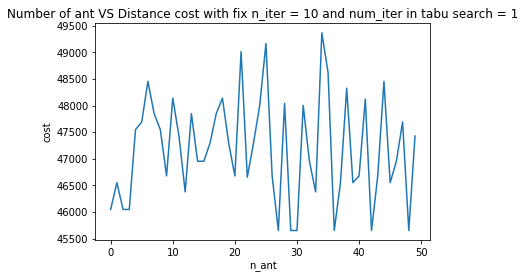

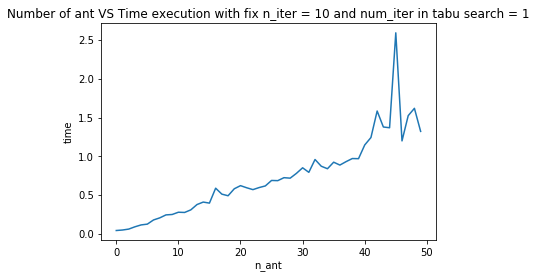

In [9]:
import time
n_iter = 10
n_ant = 50
list_cost = []
list_time = []
for i in range(n_ant):
    start = time.time() #collect start time
    num_iter = 1 #number of iteration for Tabu search
    neighbors = np.zeros((N, sol_len +2), dtype=int) 
    solc = solcost(aco(n_iter,i))
    end = time.time() #collect end time
    list_cost.append(solc)
    list_time.append(end - start)
list_cost, list_time
from matplotlib import pyplot as plt
#plot cost
plt.plot(list_cost)
plt.xlabel('n_ant')
plt.ylabel('cost')
plt.title('Number of ant VS Distance cost with fix n_iter = 10 and num_iter in tabu search = 1')
plt.show()

#plot time execution
plt.plot(list_time)
plt.xlabel('n_ant')
plt.ylabel('time')
plt.title('Number of ant VS Time execution with fix n_iter = 10 and num_iter in tabu search = 1')
plt.show()

### Choosing the parameters: number of iterations

Best ACO solution: [4, 3, 2, 0, 1]
Best ACO solution: [0, 2, 4, 1, 3]
Best ACO solution: [3, 0, 2, 4, 1]
Best ACO solution: [4, 0, 1, 2, 3]
Best ACO solution: [4, 1, 3, 2, 0]
Best ACO solution: [2, 0, 1, 4, 3]
Best ACO solution: [2, 3, 1, 4, 0]
Best ACO solution: [0, 4, 3, 2, 1]
Best ACO solution: [2, 1, 3, 4, 0]
Best ACO solution: [2, 3, 1, 4, 0]
Best ACO solution: [1, 2, 3, 4, 0]
Best ACO solution: [2, 3, 1, 4, 0]
Best ACO solution: [0, 3, 2, 4, 1]
Best ACO solution: [4, 0, 1, 2, 3]
Best ACO solution: [4, 0, 1, 2, 3]
Best ACO solution: [1, 2, 0, 4, 3]
Best ACO solution: [4, 3, 0, 2, 1]
Best ACO solution: [1, 0, 3, 4, 2]
Best ACO solution: [2, 0, 1, 4, 3]
Best ACO solution: [3, 0, 1, 4, 2]
Best ACO solution: [2, 3, 0, 4, 1]
Best ACO solution: [1, 0, 3, 4, 2]
Best ACO solution: [2, 3, 0, 4, 1]
Best ACO solution: [1, 2, 3, 4, 0]
Best ACO solution: [1, 0, 2, 4, 3]
Best ACO solution: [2, 1, 0, 4, 3]
Best ACO solution: [2, 3, 1, 4, 0]
Best ACO solution: [2, 3, 0, 4, 1]
Best ACO solution: [

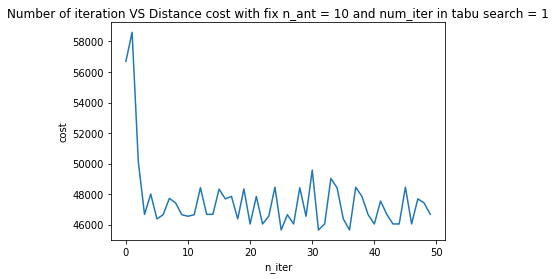

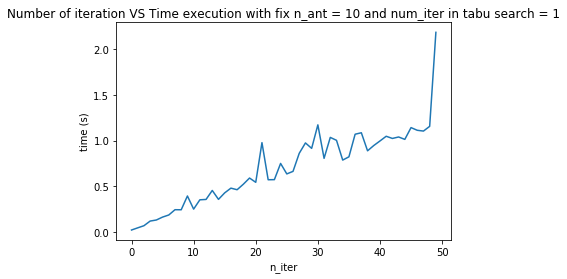

In [10]:
n_iter = 50
n_ant = 10
list_cost = []
list_time = []
for i in range(n_iter):
    start = time.time() #collect start time
    num_iter = 1 #number of iteration for Tabu search
    neighbors = np.zeros((N, sol_len +2), dtype=int) #set iteration matrix for Tabu search
    solc = solcost(aco(i,n_ant))
    end = time.time() #collect end time
    list_cost.append(solc)
    list_time.append(end - start)
list_cost, list_time
#from matplotlib import pyplot as plt
#plot cost
plt.plot(list_cost)
plt.xlabel('n_iter')
plt.ylabel('cost')
plt.title('Number of iteration VS Distance cost with fix n_ant = 10 and num_iter in tabu search = 1')
plt.show()

#plot time execution
plt.plot(list_time)
plt.xlabel('n_iter')
plt.ylabel('time (s)')
plt.title('Number of iteration VS Time execution with fix n_ant = 10 and num_iter in tabu search = 1')
plt.show()

### Summary from plots

- Distance cost dose not improve when increasing number of ants while fix other parameters.
- After a few iterations of increasing number of iteration in Ant colony algorithm the distance cost fall down to range 45k-49k and swing up and down between this range all the obsearvation.
- After 4 iterations when increasing number of iteration for Tabu search, the distance cost alway stable.
- Time execution and increasing number of iterations and ants in Ant colony have linear relationship.
- The relationship between number of iteration for Tabu search and time consuming is not stable which mean the number of iteration for Tabu search not directly consume computer resource if the model can find the best solution early or fall to some logics that contain break function.